In [67]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA  
import math

In [14]:
# !pip install fitter

In [4]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [36]:
data = pd.read_csv('Train/Compiled.csv')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   33600 non-null  int64  
 1   index        33600 non-null  int64  
 2   load         33600 non-null  float64
 3   pressure     33600 non-null  float64
 4   cloud_cov    33600 non-null  float64
 5   humid        33600 non-null  float64
 6   temp         33600 non-null  float64
 7   wind_dir     33600 non-null  float64
 8   wind_sp      33600 non-null  float64
 9   pressure_f   33600 non-null  float64
 10  cloud_cov_f  33600 non-null  float64
 11  temp_f       33600 non-null  float64
 12  wind_dir_f   33600 non-null  float64
 13  wind_sp_f    33600 non-null  float64
 14  date         33600 non-null  object 
 15  month        33600 non-null  int64  
 16  hour         33600 non-null  int64  
 17  type_of_day  33600 non-null  int64  
 18  day          33600 non-null  int64  
 19   yea

In [38]:
data['datetime'] = pd.to_datetime(data['datetime'])

/var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/ipykernel_22326/2412623082.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['datetime'])


In [39]:
lagged_data = pd.read_csv('/Users/emanatassi/Downloads/FIT3164/Lags.csv')

In [40]:
lagged_data['datetime'] = pd.to_datetime(lagged_data['datetime'])

/var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/ipykernel_22326/586995564.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lagged_data['datetime'] = pd.to_datetime(lagged_data['datetime'])


In [41]:
data.set_index('datetime', inplace=True)
lagged_data.set_index('datetime', inplace=True)

In [42]:
load = data.load
differenced_load = data.load.diff(1).dropna()

In [43]:
unlagged_x = data.drop(columns=['date', 'load', 'Unnamed: 0', 'index'])
lagged_x = lagged_data.drop(columns=['date', 'load_L0', 'Unnamed: 0', 'index'])
y = load # use load or differenced

## Checking if data is stationary:

Data must be stationary for SARIMA and exponential smoothing.

<AxesSubplot:xlabel='datetime'>

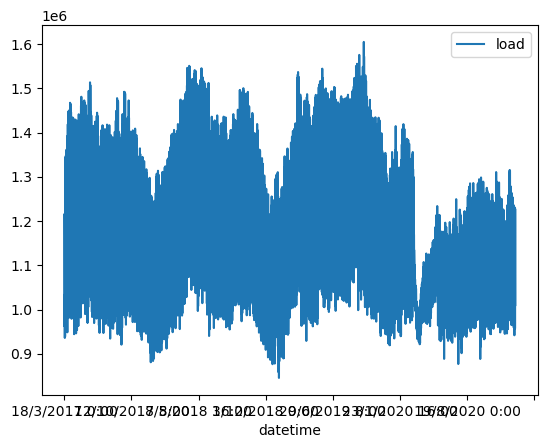

In [7]:
data.plot('datetime', 'load')

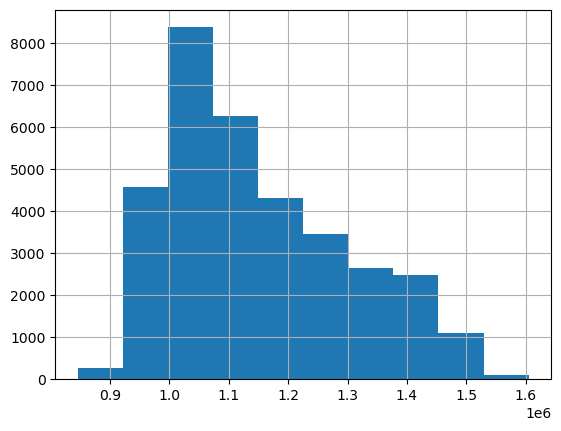

In [9]:
data.load.hist()
plt.show()

In [ ]:
lagged_data = pd

### Auto-correlation:

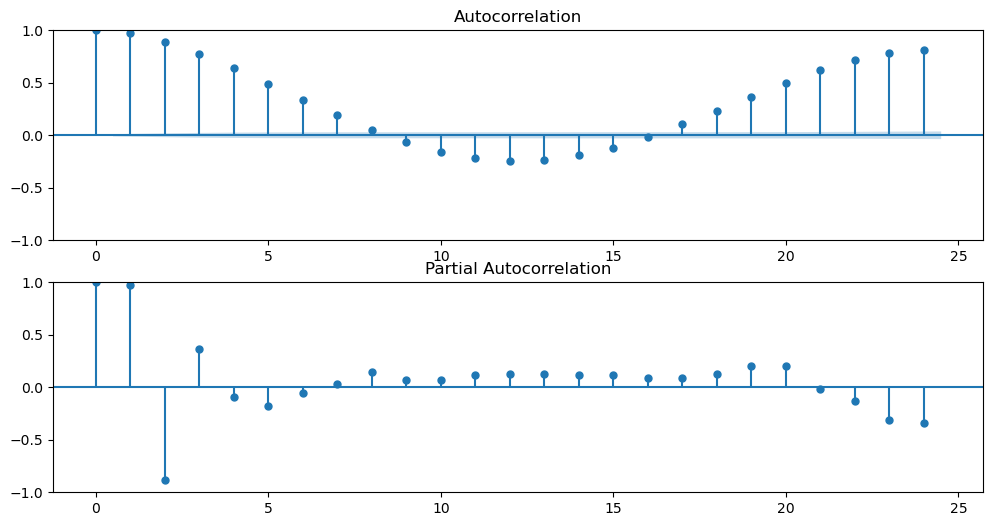

In [11]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.load.dropna(), ax=ax[0], lags=24)
ax[1] = plot_pacf(data.load.dropna(), ax=ax[1], lags=24)

### Augmented Dickey-Fuller Test:

In [11]:
print(" > Is the data stationary? Before differencing:")
dftest = adfuller(data.load, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary? Before differencing:
Test statistic = -13.315
P-value = 0.000
Critical values :
	1%: -3.4305449444195664 - The data is  stationary with 99% confidence
	5%: -2.8616261604986013 - The data is  stationary with 95% confidence
	10%: -2.566815860545899 - The data is  stationary with 90% confidence


P-value is definitely less than 0.05, which indicates that the data IS stationary. However, to be safe, we'll do differencing.

In [14]:
print(" > After differencing: ")
dftest = adfuller(differenced_load, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.50f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > After differencing: 
Test statistic = -34.461
P-value = 0.00000000000000000000000000000000000000000000000000
Critical values :
	1%: -3.4305449502312677 - The data is  stationary with 99% confidence
	5%: -2.861626163067142 - The data is  stationary with 95% confidence
	10%: -2.5668158619130677 - The data is  stationary with 90% confidence


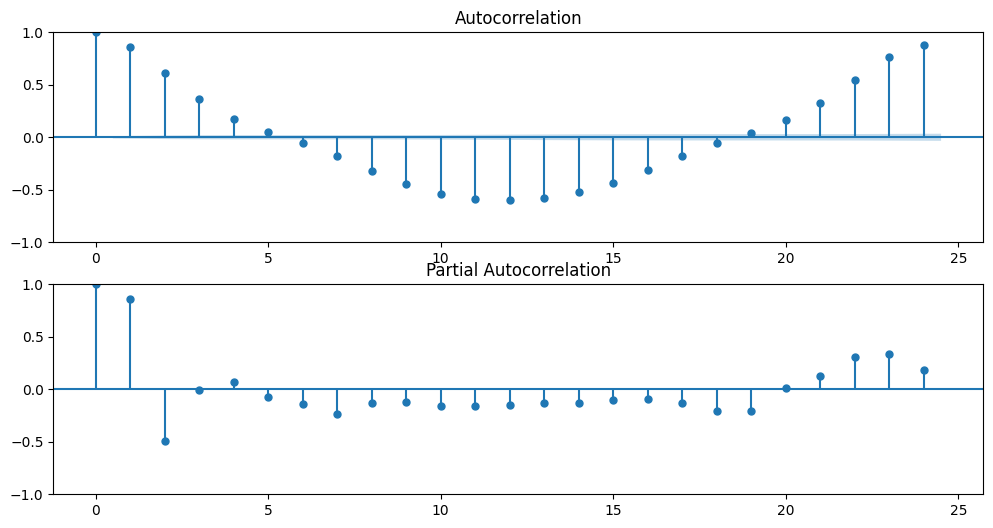

In [17]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(differenced_load, ax=ax[0], lags=24)
ax[1] = plot_pacf(differenced_load, ax=ax[1], lags=24)

## Determining the distribution of the data:

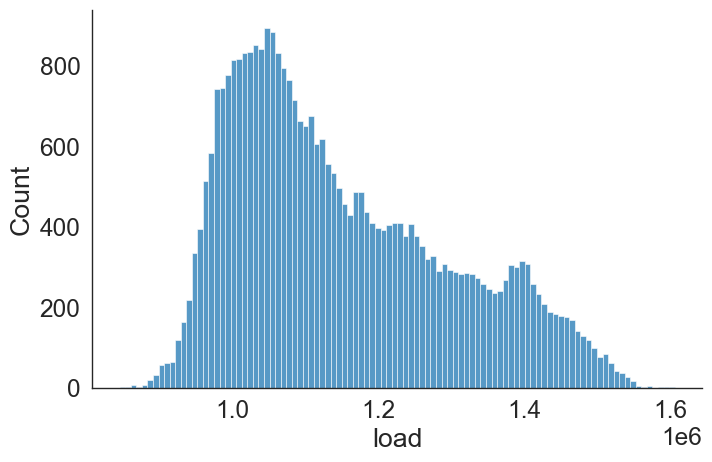

In [17]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=data, x="load", kind="hist", bins = 100, aspect = 1.5)

In [24]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.00000,2841.28424,2866.55108,0.04726,0.04175,0.00000
gamma,0.00000,2832.50329,2857.77013,0.05116,0.04696,0.00000
chi2,0.00000,2843.12035,2868.38719,0.05112,0.05180,0.00000
cauchy,0.00000,2850.14374,2866.98830,0.19317,0.14524,0.00000
norm,0.00000,2812.66158,2829.50614,0.14428,0.09816,0.00000


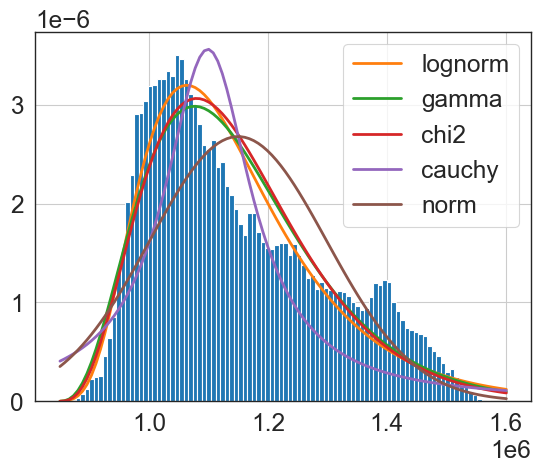

In [25]:
f = Fitter(load,
           distributions=get_common_distributions())
f.fit()
f.summary()

In [27]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.4426388100598154,
  'loc': 807330.9346729426,
  'scale': 310955.369943159}}

In [28]:
f.fitted_param["lognorm"] # finds the fitted paramaters

(0.4426388100598154, 807330.9346729426, 310955.369943159)

## Preparing errror measures:

In [44]:
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted)/actual))*100

def calculate_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

## Preparing a DataFrame to put all the error measures in for all models:

In [96]:
models_eval = pd.read_csv('Train/models_eval.csv') # append to this dataframe your model's measures

In [97]:
models_eval.drop(columns='Unnamed: 0', inplace=True)

In [28]:
# models_eval.to_csv('Train/models_eval.csv') # save once you're done

## Preparing train and test data:

This can be used for all the models ig?

In [46]:
def non_shuffling_train_test_split(X, y, test_size=0.3):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

In [47]:
train_unlagged_x, test_unlagged_x, train_unlagged_y, test_unlagged_y = non_shuffling_train_test_split(
        unlagged_x, y, test_size = 0.3)

In [48]:
train_lagged_x, test_lagged_x, train_lagged_y, test_lagged_y = non_shuffling_train_test_split(
        lagged_x, y, test_size = 0.3)

## SARIMA:

Testing on unlagged data. This already takes up WAY too much time which indicates that it cannot handle lagged data. 

In [ ]:
SARIMAX_model = auto_arima(train_unlagged_y,
                           seasonal=True, 
                           m=24,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=112.99 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=564651.598, Time=0.39 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=519855.632, Time=18.47 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=540271.835, Time=14.83 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=564649.598, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=534463.030, Time=1.06 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=118.53 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=93.23 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=524948.489, Time=17.74 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=750.84 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=29.69 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=515870.985, Time=23.29 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=528280.540, Time=1.40 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=153.23 sec
 ARIMA(2,1,0)(1,0,1

In [1]:
SARIMAX_model.summary()

NameError: name 'SARIMAX_model' is not defined

In [79]:
# define model configuration
my_order = (1,0,0)
my_seasonal_order = (2,0, 0, 24)
# define model
sarimax_model2 = SARIMAX(train_unlagged_y, order=my_order, seasonal_order=my_seasonal_order)

/Users/emanatassi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/emanatassi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [80]:
sarimax_model_fit = sarimax_model2.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16195D+01    |proj g|=  1.54904D-02

At iterate    5    f=  1.16189D+01    |proj g|=  4.15332D-03

At iterate   10    f=  1.16132D+01    |proj g|=  4.26643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     28      1     0     0   1.980D-05   1.161D+01
  F =   11.613231520406055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [81]:
sarimax_pred = sarimax_model_fit.predict(start=len(train_unlagged_y), end=(len(train_unlagged_y)+ len(test_unlagged_y)-1))                                                                                

In [82]:
sarimax_pred

2019-11-23 01:00:00   1063181.39363
2019-11-23 02:00:00   1044603.59626
2019-11-23 03:00:00   1030310.15752
2019-11-23 04:00:00   1022841.38649
2019-11-23 05:00:00   1032974.33878
                           ...     
2021-01-15 19:00:00      2589.48204
2021-01-15 20:00:00      2587.94712
2021-01-15 21:00:00      2586.41311
2021-01-15 22:00:00      2584.88000
2021-01-15 23:00:00      2583.34781
Freq: H, Name: predicted_mean, Length: 10079, dtype: float64

In [83]:
test_unlagged_y

datetime
2019-11-23 01:00:00   1066785.04800
2019-11-23 02:00:00   1041785.04800
2019-11-23 03:00:00   1026285.04800
2019-11-23 04:00:00   1015785.04800
2019-11-23 05:00:00   1023785.04800
                           ...     
2021-01-15 19:00:00   1141078.93200
2021-01-15 20:00:00   1108896.43200
2021-01-15 21:00:00   1078978.43200
2021-01-15 22:00:00   1044494.93200
2021-01-15 23:00:00   1010233.93200
Name: load, Length: 10079, dtype: float64

<Axes: xlabel='datetime'>

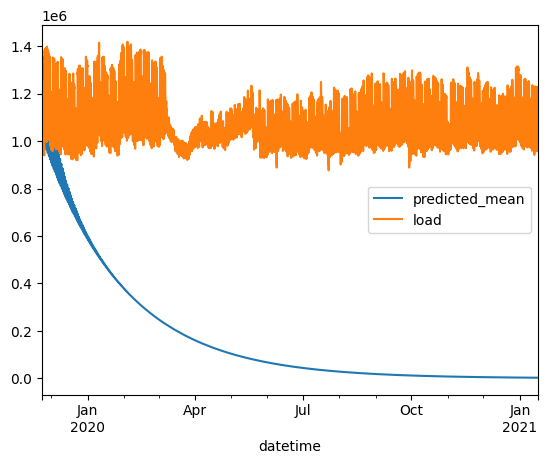

In [84]:
sarimax_pred.plot(legend=True)
test_unlagged_y.plot(legend=True)

WHAAATTTTT!!!!!

<Axes: xlabel='datetime'>

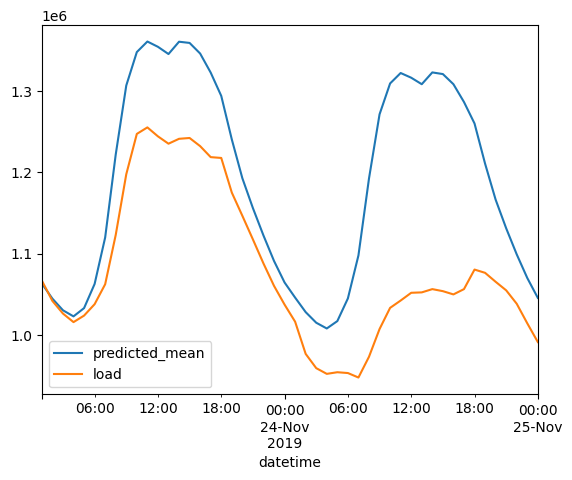

In [85]:
sarimax_model_fit.predict(start=len(train_unlagged_y), end=len(train_unlagged_y)+48-1)                                 .plot(legend=True)
test_unlagged_y[:48].plot(legend=True)


In [86]:
mae = calculate_mae(test_unlagged_y, sarimax_pred)
mape = calculate_mape(test_unlagged_y, sarimax_pred)
rmse = calculate_rmse(test_unlagged_y, sarimax_pred)

print('MAE: '+ str(mae))
print('MAPE: '+ str(mape))
print('RMSE: '+ str(rmse))

MAE: 908540.2124779637
MAPE: 84.16571418849652
RMSE: 943228.7995406511


In [98]:
row = {'Model': 'SARIMA', 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}
models_eval = pd.concat([models_eval, pd.DataFrame([row])], ignore_index=True)

In [99]:
models_eval

,Model,MAE,MAPE,RMSE
0,SARIMA,908540.21248,84.16571,943228.79954


In [100]:
models_eval.to_csv('Train/models_eval.csv')